# Anomaly Detection with Pattern Dictionaries

### 1. Markey-Glass Series
以Markey-Glass Series为例，证明模式字典算法的异常检测功能

#### 1.1 准备数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import signalz
from utils import *

# 生成正常数据
N = 10000
train_N = 3000
test_N = 1500
original_data = signalz.mackey_glass(N, a=0.2, b=0.5, c=0.9, d=23, e=10, initial=0.1)
train_set = original_data[1000:1000+train_N]
test_set = original_data[5000:5000+test_N]

# 生成异常数据,嵌入到测试集中
anomaly_data = signalz.mackey_glass(N, a=0.3, b=0.8, c=0.9, d=23, e=10, initial=0.1)
anomaly_slice = anomaly_data[5500:6000]
print(len(anomaly_slice))

start, end = 0, 0
while abs(original_data[5500+start]-anomaly_slice[0]) > 1e-3:
  start += 1

while abs(original_data[6000+end]-anomaly_slice[-1]) > 1e-3:
  end += 1

print(f"shift: {5500+start}, {6000+end}")

test_set[:500] = original_data[5000+start:5500+start]
test_set[500:1000] = anomaly_slice
test_set[1000:] = original_data[6000+end:6000+end+500]

# 数据离散化
num_bins = 100

min_val = min(train_set)
max_val = max(train_set)
d_train_set,_ = uniform_quantization(train_set, min_val, max_val, num_bins)
d_test_set,test_alphabet = uniform_quantization(test_set, min_val, max_val, num_bins)

500
shift: 5551, 7166


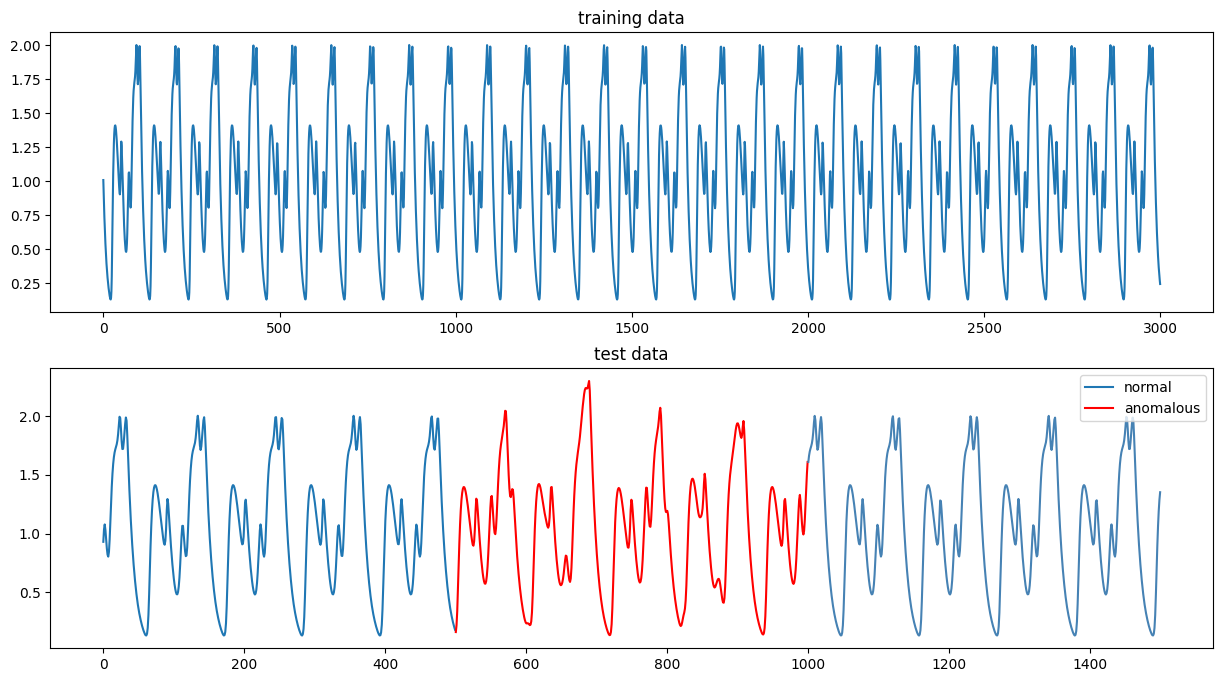

In [2]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))
axs[0].plot(np.arange(train_N), train_set)
axs[1].plot(np.arange(test_N)[:500], test_set[:500], label="normal")
axs[1].plot(np.arange(test_N)[500:1000], test_set[500:1000], color="red", label="anomalous")
axs[1].plot(np.arange(test_N)[1000:], test_set[1000:], color="steelblue")

axs[0].title.set_text("training data")
axs[1].title.set_text("test data")

plt.legend()
plt.show()

#### 1.2. PDD

In [3]:
class PDD:
	def __init__(self, max_D, dataFlow=False):
		self.max_D = max_D  # maximum code depths
		self.pattern_dict = dict()  # {code_depth: patterns}
		self.code_scheme = dict()  # {code_depth: code schemes}

	def train(self, source):
		"""build pattern dictionary"""
		code_depth = 1
		while code_depth <= self.max_D:
			self._train_depth(source, code_depth)
			code_depth += 1

	def init_alphabet(self, alphabet):
		"""initialize full alphabet"""
		code_depth = 1
		if code_depth not in self.pattern_dict:
			self.pattern_dict[code_depth] = {}
		# 对于code_depth=1时，需要ALPHABET完全补足
		self.pattern_dict[code_depth] = {tuple([key]): 0 for key in alphabet}

	def build_code_scheme(self):
		"""build huffman coding tree"""
		code_depth = 1
		while code_depth <= self.max_D:
			pattern_tb = self.pattern_dict[code_depth]
			codes = [code for code in pattern_tb.keys()]
			freqs = np.array([freq for freq in pattern_tb.values()])
			code_dict = build_huffman_tree(codes, freqs)

			# 记录每个短语的码字长度
			code_lengths = {phrase: len(code) for phrase, code in code_dict.items()}

			# 存储编码方案和码字长度
			self.code_scheme[code_depth] = {'codes': code_dict, 'lengths': code_lengths}
			code_depth += 1

	def _train_depth(self, source, code_depth):
		"""get pattern dict with given code_depth"""
		if code_depth not in self.pattern_dict:
			self.pattern_dict[code_depth] = {}

		pattern_dict = self.pattern_dict[code_depth]
		for start in range(len(source) - code_depth + 1):
			substr = tuple(source[start:start + code_depth])  # use tuple as key
			if substr not in pattern_dict:
				pattern_dict[substr] = 1
			else:
				pattern_dict[substr] += 1
		self.pattern_dict[code_depth] = pattern_dict

	def parse(self, data):
		encoded = []

		v_c = 0
		depth = 1

		while v_c + depth - 1 < len(data):
			phrase = tuple(data[v_c:v_c + depth])
			if phrase in self.pattern_dict[depth]:
				if depth < self.max_D:
					depth += 1
				else:
					code_info = self.code_scheme[depth]
					code_length = code_info['lengths'][phrase]
					encoded.append((phrase, code_length))

					v_c += depth
					depth = 1
			else:
				phrase = tuple(data[v_c:v_c + depth - 1])
				code_info = self.code_scheme[depth]
				code_length = code_info['lengths'][phrase]
				encoded.append((phrase, code_length))

				v_c += depth - 1
				depth = 1

		# 处理最后的短语
		if v_c < len(data):
			phrase = tuple(data[v_c:])
			code_info = self.code_scheme[len(phrase)]
			code_length = code_info['lengths'][phrase]
			encoded.append((phrase, code_length))

		return encoded  # 返回 (phrase, code_length) 的列表


	def get_total_bits(self, encoded_result):
		total_bits = 0
		c = len(encoded_result)
		for _, code_length in encoded_result:
			total_bits += code_length  # 累加每个短语的编码长度
		total_bits += c * math.log2(self.max_D)  # 加上每个短语指示深度的位数
		return total_bits

In [4]:
from huffman import *
import math

max_D = 15
window_size = 100

# PDD
encoder = PDD(max_D)
encoder.init_alphabet(d_train_set)

for i_seq in range(0, len(train_set)-window_size, 1):
    subseq = d_train_set[i_seq:i_seq+window_size]
    encoder.train(subseq)
encoder.build_code_scheme()

PDD_score = []
for i_seq in range(0, len(test_set)-window_size, 1):
    subseq = d_test_set[i_seq:i_seq+window_size]
    c_subseq = encoder.parse(subseq)
    PDD_score.append(encoder.get_total_bits(c_subseq))

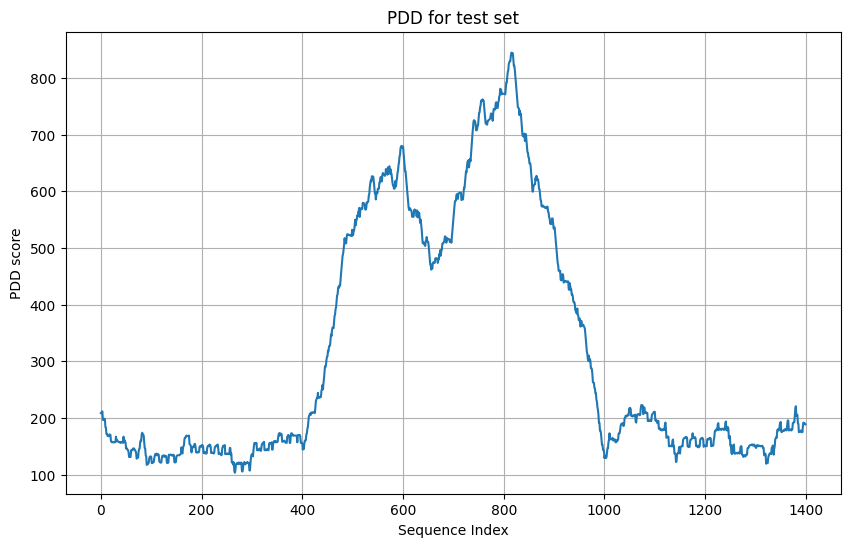

In [5]:
plt.figure(figsize=(10,6))
plt.plot(PDD_score)
plt.xlabel('Sequence Index')
plt.ylabel('PDD score')
plt.title('PDD for test set')
plt.grid(True)
plt.show()

#### 1.3. PDA

In [6]:
from lz78_parser import *

lz78_encoder = LZ78()
lz78_encoder.train(d_test_set)

LZ78_score = []
for i_seq in range(0, len(test_set)-window_size, 1):
    subseq = d_test_set[i_seq:i_seq+window_size]
    c_subseq = lz78_encoder.encode(subseq)
    LZ78_score.append(lz78_encoder.get_total_bits(c_subseq))

test_score = [a-b for a,b in zip(PDD_score,LZ78_score)]

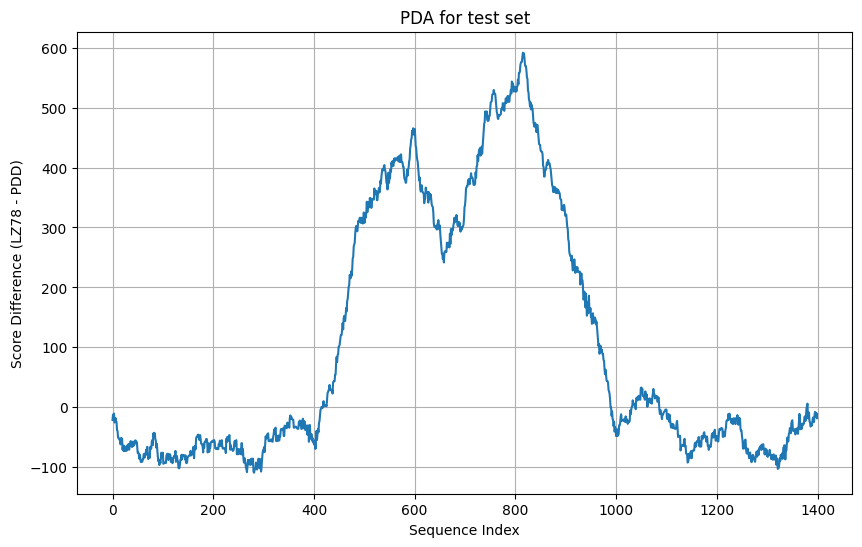

In [7]:
plt.figure(figsize=(10,6))
plt.plot(test_score)
plt.xlabel('Sequence Index')
plt.ylabel('Score Difference (LZ78 - PDD)')
plt.title('PDA for test set')
plt.grid(True)
plt.show()

### 1.3 可视化

In [14]:
theta = 0.3

test_anomalies_i = set() # 统计测试集的异常数据
for (i, num) in enumerate(test_score):
    if num > theta*window_size: # 定义超出标准指标 20% 的数据作为异常数据
      test_anomalies_i.add(i)

# 数据评估
true_anomalies_i = set([i for i in range(500, 1000)])

TP = len(test_anomalies_i.intersection(true_anomalies_i))
FP = len(test_anomalies_i.difference(true_anomalies_i))
FN = len(true_anomalies_i.difference(test_anomalies_i))

print(f"Test: {len(test_score)} samples")
print(f"Detected anomalies: {len(test_anomalies_i)}")
print(f"Precision: {TP/(TP+FP):.4f}")
print(f"Recall: {TP/(TP+FN):.4f}")

Test: 1400 samples
Detected anomalies: 552
Precision: 0.8786
Recall: 0.9700


In [15]:
test_anomalies_i = set() # 统计测试集的异常数据
for (i, num) in enumerate(test_score):
    if num > theta*window_size: # 定义超出标准指标 20% 的数据作为异常数据
      test_anomalies_i.add(i)

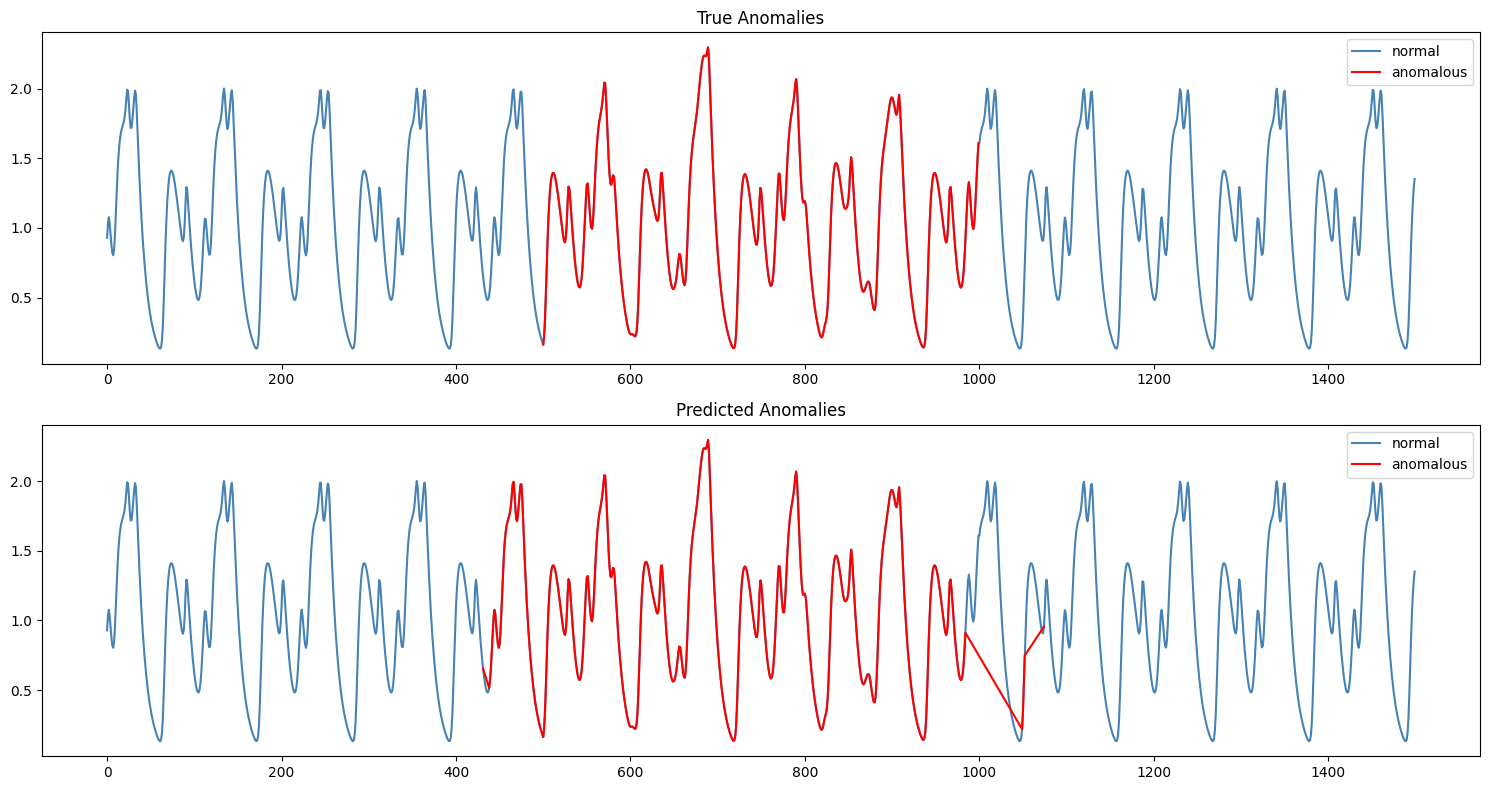

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

axs[0].plot(np.arange(test_N), test_set, color='steelblue', label='normal')
axs[0].plot(np.arange(test_N)[500:1000], test_set[500:1000], color='red', label='anomalous')
axs[0].set_title('True Anomalies')
axs[0].legend()

axs[1].plot(np.arange(test_N), test_set, color='steelblue', label='normal')
anomaly_indices = sorted(list(test_anomalies_i))
axs[1].plot(anomaly_indices, test_set[anomaly_indices], color='red', label='anomalous')
axs[1].set_title('Predicted Anomalies')
axs[1].legend()

plt.tight_layout()
plt.show()

### 2. MIT-BIH Arrhythmia Database
用该数据集测试该算法在实际应用的效果，并开发该算法的应用

In [26]:
import wfdb

file_path = "./data/mit-bih-arrhythmia-database-1.0.0"
data_name = [str(i) for i in range(100, 125)] + [str(i) for i in range(200, 235)] # 该数据集的数据文件名

tmp_data = file_path + '/' + data_name[0]

record = wfdb.rdrecord(tmp_data)
signals, fs = record.p_signal,record.fs
annotations = wfdb.rdann(tmp_data, 'atr')

plt.figure(figsize=(15, 5))
wfdb.plot_wfdb(record=record, 
               annotation=annotations,
               title='ECG with Annotations')

OverflowError: Python integer 256 out of bounds for uint8